# Launcher

SeDef - это модуль для обработки данных сейсмических событий. Получаемая информация представляет собой разрозненное облако точек. Для его размещения на регулярной сетке в пространстве и во времени, а также последующего анализа, модуль предоставляет широкой набор методов.

Однако, работать с большим количеством функций может быть не очень удобно. Получаются слишком громоздкие конструкции из кода. Launcher призван решить эту проблему.

## Основная концепция

Launcher - это выскокуровневая обвязка над функциями и классами в библиотеке SeDef. Представляет из себя конструктор, позволяющий запускать определенные блоки. Блоки представляются в виде словарей. 

Словари с параметрами вызываемых преобразований помещаются в словарь-конфигурацию для запуска операций.

Давайте рассмотрим на примере:

In [7]:
import pandas as pd

from sedef.launch import Launcher

import warnings
warnings.filterwarnings("ignore")

Загружаем датафрейм с данными для примера. В наборе имеются 6 столбцов и 50 строк. Каждая строчка - событие, зафиксированное в точке трёхмерного пространства (координаты X, Y, Z) в произвольный момент времени.

Описание столбцов:
* Datetime - время события
* Seismic_event - тип сейсмического события
* Energy - зафиксированное значение энергии
* X, Y, Z - координаты в пространстве

In [8]:
df = pd.read_csv('./datasets/cluster_example_dataset.csv')
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.head(3)

,Datetime,Seismic_event,X,Y,Z,Energy
0,2019-02-01 03:40:09,13,29856,40224,341,1050.0
1,2019-02-01 03:45:18,0,31656,39579,424,1240.0
2,2019-02-01 04:23:06,0,30489,40293,412,125000.0


## Визуализация

Для начала давайте посмотрим на массив с данными. Для этого запустим простую функцию из арсенала SeDef'а, а затем уже перейдем к запуску Launcher'а.

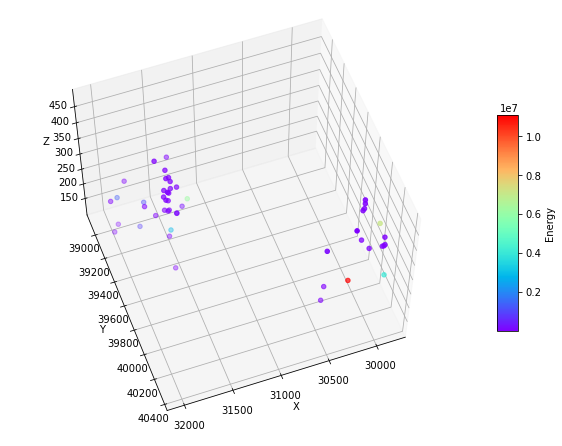

In [9]:
from sedef.visualization.static import plot_3d_simple

from pylab import rcParams
rcParams['figure.figsize'] = 8, 6

plot_3d_simple(dataframe=df,
               columns_to_show={'x': 'X',
                                'y': 'Y',
                                'z': 'Z',
                                'target': 'Energy'},
               view_init=(60, 70))

Таким образом, мы вывели на экран статичную визуализацию исходныйх данных. Если бы мы запустили Launcher, то описанное выше действие - это один блок обработки.

## Launcher простой пример

Попробуем сделать то же самое при помощи Launcher'а. Создадим словарь 'params_3d_vis' с теми же параметрами, что и для функции выше. Поместим параметры операции в словарь-конфигурацию и запустим.

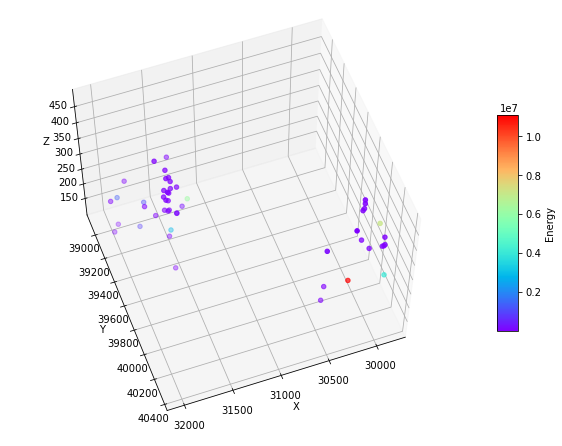

In [10]:
params_3d_vis = {'columns_to_show': {'x': 'X', 'y': 'Y',
                                     'z': 'Z', 'target': 'Energy'},
                 'view_init': (60, 70)}

configuration = {'3D show static': params_3d_vis}

# Запуск алгоритма
launcher = Launcher(dataframe=df, datetime_column='Datetime')

# Так как мы использовали только функцию визуализации - final_dataframe
# это ровно тот же самый датафрейм, который мы указали при инициализации класса
final_dataframe = launcher.run(configuration=configuration)

Мы получили ту же самую картинку. Неплохо, но весь потенциал Launcher'а раскрыввается при построении продолжительных пайплайнов.

Доступные обязательные операции:
* 'Create clusters with centroids' - кластеризация при помощи hdbscan и расчет центроидов кластеров по заданным координатам;
* 'Set time step' - задание временного шага для составления временного ряда;
* 'Merge and tense' - стягивание выбранных переменных (вещественных или категориальных) в центроиды кластеров и к соответствующим временным меткам;
* 'SSA' - анализ временных рядов.

Доступные дополнительные операции:
* 'Find optimal time step' - алгоритм подбора оптимального шага дискретизации;
* '3D show static' - график с исходными объектами в датафрейме;
* '3D show clusters static' - график с центроидами выделенных кластеров;
* '3D show interactive' - график с исходными объектами в датафрейме (plotly);
* 'Line show interactive' - график с получившимися временными рядами для разных кластеров.

Обязательные операции будут выполняться в определенном порядке: не получиться запустить 'Merge and tense' блок без предварительного решения задачи кластеризации 'Create clusters with centroids'. Тем не менее, если нет необходимости использовать 'SSA', то цепочку можно ограничить блоками 'Create clusters with centroids' -> 'Set time step' -> 'Merge and tense' - противоречий в модуле это не вызовет.

## Launcher расширенный пример

Далее запустим несколько блоков, как обязательных так и опциональных.

Warning! During the "Find optimal time step" operation there will be defined optimal time step, so operation "Set time step" with pre-defined parameter time_step will be ignored


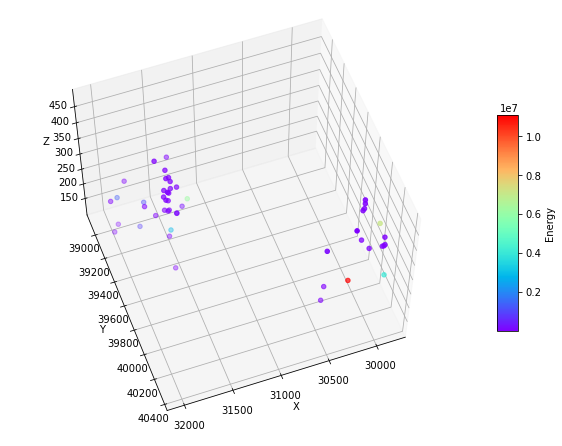

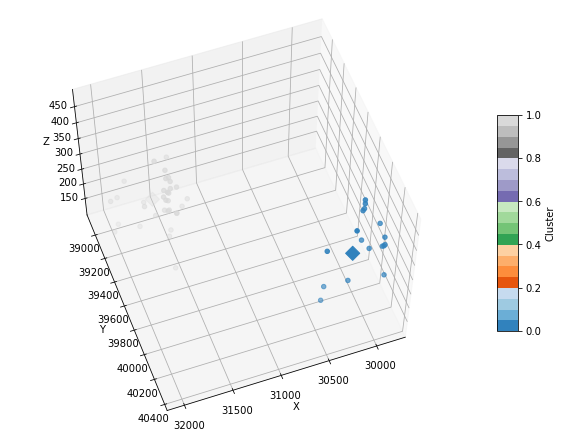

For a time step 3033 sec. gap score (amount of gaps) - 2 and collision score (amount of elements in collisions/amount of collisions) - 6.2
Optimal common score - 4.1


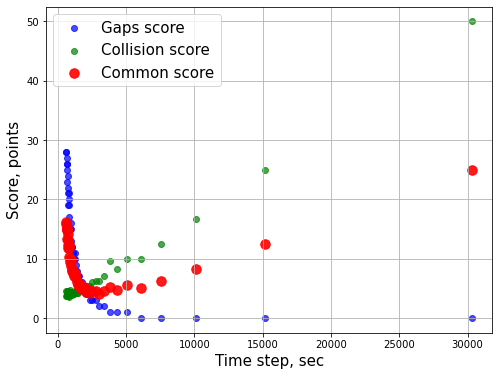


The time series will be composed with frequency - 3033s
Start date - 2019-02-01 00:00:00
Final date - 2019-02-10 00:00:00


In [11]:
# Параметры для 3D визуализации 
params_3d_vis = {'columns_to_show': {'x': 'X', 'y': 'Y',
                                     'z': 'Z', 'target': 'Energy'},
                 'view_init': (60, 70)}

# Кластеризация
params_for_clustering = {'min_cluster_size': 10,
                         'min_samples': 10,
                         'list_columns': ['X', 'Y', 'Z']}

# Поиск оптимального временного шага для датасета
params_for_search = {'collision_w': 0.5,
                     'gaps_w': 0.5,
                     'vis': True,
                     'method': 'brute'}

# Дискретизация временного ряда
# Так как используется 'Find optimal time step' - нет необходимости
# задавать временной шаг дискретизации вручную 
params_for_setting = {'start_date': '2019-02-01 00:00:00',
                      'end_date': '2019-02-10 00:00:00',
                      'time_step': None}

# Параметры для операции стягивания значений
params_for_merge = {'list_columns': ['X', 'Y', 'Z'],
                    'target_regression': 'Energy',
                    'target_classification': 'Seismic_event'}


# Словарь-конфигурация
configuration = {'3D show static': params_3d_vis,
                 'Create clusters with centroids': params_for_clustering,
                 '3D show clusters static': params_3d_vis,
                 'Find optimal time step': params_for_search,
                 'Set time step': params_for_setting,
                 'Merge and tense': params_for_merge}

launcher = Launcher(dataframe=df, datetime_column='Datetime')
final_dataframe = launcher.run(configuration=configuration)

Посмотрим на получившийся датасет:

In [12]:
final_dataframe.head(5)

,Datetime,Seismic_event,X,Y,Z,Energy,Cluster,X_centroid,Y_centroid,Z_centroid,New_datetime
0,2019-02-01 03:40:09,13.0,29856.0,40224.0,341.0,1050.0,0.0,30172.0,40210.5,338.0,2019-02-01 03:47:28.500
1,2019-02-01 03:45:18,0.0,31656.0,39579.0,424.0,1240.0,1.0,31664.5,39254.0,271.0,2019-02-01 03:47:28.500
2,2019-02-01 04:23:06,0.0,30489.0,40293.0,412.0,63615.0,0.0,30172.0,40210.5,338.0,2019-02-01 04:38:01.500
3,2019-02-01 04:37:39,0.0,31566.0,39405.0,343.0,2470.0,1.0,31664.5,39254.0,271.0,2019-02-01 04:38:01.500
5,2019-02-01 05:13:29,0.0,30051.0,40153.0,346.0,472.0,0.0,30172.0,40210.5,338.0,2019-02-01 05:28:34.500


Он действительно притерпел изменения: появились колонки с метками присвоенных кластеров и рассчитанные центроиды кластеров. Новые временные метки в столбце New_datetime, а также обновились значения в столбцах Seismic_event и Energy, так как значения были смещены в центроиды кластеров и новые временные метки.

Теперь обратим внимание на поиск оптимального временного шага (3й график сверху). Алгоритм поиска временного шага находит баланс между количеством пропусков и количеством коллизий.
Под пропуском понимается отсутствие каких-либо значений для временной метки. Под коллизией понимается случай, когда одной временной метке в результате преобразования могут быть присвоены сразу несколько значений, следовательно, производится усреднение.

На графике показаны рассмотренные в ходе оптимизации решения. Задача многокритериальной оптимизации в данном случае сводится к задачи однокритериальной при помощи усреднения с весами целевых функций (gaps score и collision score). Gaps score показывает общее количество пропусков при выбранной длине временного шага. Collision score - (общее количество исходных объектов в коллизиях) / (количество временных меток с коллизиями).